<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Digital Wage Payment Prediction</h1> 
<h2 style="text-align: center;" markdown="2">An AIMS Masters project in Collaboration with the Global Centre on Digital Wages for Decent Work (ILO)</h2>


> *The widespread adoption of digital payments has become increasingly important. In light of this, the aim of this project is to investigate the probability of an individual receiving digital wages in Africa. To achieve this, a series of empirical comparative assessments of machine learning classification algorithms will be conducted. The objective is to determine the effectiveness of these algorithms in predicting digital wage payments. Therefore, this notebook forms part of a larger project that seeks to explore the potential of machine learning in addressing issues related to financial inclusion in Africa.*

<h1 style="text-align: center;" markdown="3">Algorithm 4 - XGBoost Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Demographic Feature Set</h2> 

# Table of Contents

[Introduction](#setup)  
[No Sample Weights](#noweights)    
[Sample Weights](#weights)  
[Cross-Validation and Parameter Tuning](#cross-validation)   
[XGBoost Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the XGBoost classifier to the dataset. 

As always, we start with loading our standard libraries and the data

In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

from xgboost import XGBClassifier

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_data_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize


ALGORITHM_NAME = 'xgb'
COUNTRY = 'dem_merged_dumvar'

TRAIN_PATH, TEST_PATH = get_data_filepaths(COUNTRY)


# No Sample Weights <a class="anchor" id="noweights"></a>

Now let's apply the XGBoost classifier to the dataset with no weights.

In [2]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 2.01 s, sys: 21.3 ms, total: 2.03 s
Wall time: 134 ms
CPU times: user 60.6 ms, sys: 0 ns, total: 60.6 ms
Wall time: 2.45 ms
In-sample score: 81.81%


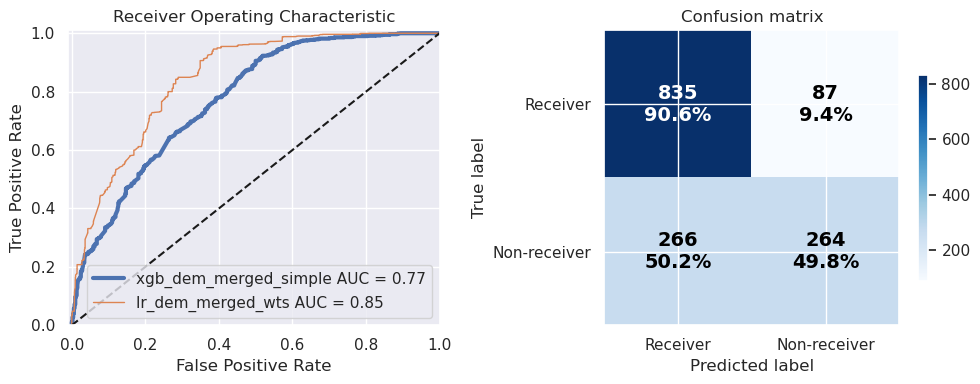

,xgb_dem_merged_simple,lr_dem_merged_wts
accuracy,0.756887,0.809847
recall,0.905640,0.946640
precision,0.758401,0.782140
f1,0.825507,0.856563
cross_entropy,0.549253,0.450266
roc_auc,0.774644,0.845867
cohen_kappa,0.434983,0.469722


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 68.30% 


In [3]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.to_numpy(), y_train)

# Get an initial score
%time score = model.score(X_train.to_numpy(), y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.to_numpy())
y_prob = model.predict_proba(X_test.to_numpy())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob,
                                    compare_models='lr_dem_merged_wts',
                                    store_model=True,
                                    model_name='dem_merged_simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

# Sample weights <a class="anchor" id="weights">

Next, we will incorporate the sample weights that came with the dataset, enabling us to generalize our model results to the overall population.

CPU times: user 1.94 s, sys: 0 ns, total: 1.94 s
Wall time: 128 ms
CPU times: user 61.2 ms, sys: 0 ns, total: 61.2 ms
Wall time: 2.4 ms
In-sample score: 89.35%


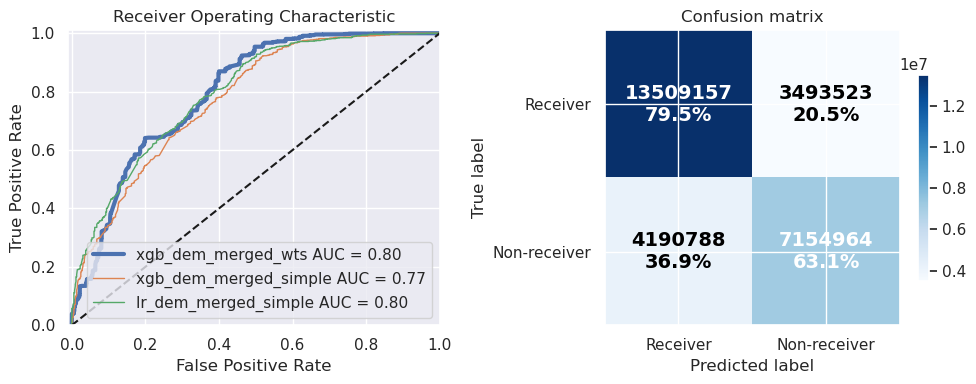

,xgb_dem_merged_wts,xgb_dem_merged_simple,lr_dem_merged_simple
accuracy,0.728933,0.756887,0.771350
recall,0.794531,0.905640,0.940347
precision,0.763232,0.758401,0.757867
f1,0.778567,0.825507,0.839303
cross_entropy,0.634165,0.549253,0.502730
roc_auc,0.797634,0.774644,0.795646
cohen_kappa,0.380615,0.434983,0.458535


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 62.68% 


In [4]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = XGBClassifier()
%time model.fit(X_train.to_numpy(), y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train.to_numpy(), y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.to_numpy())
y_prob = model.predict_proba(X_test.to_numpy())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_dem_merged_simple','lr_dem_merged_simple'],
                                    store_model=True,
                                    model_name='dem_merged_wts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Cross-validation and Parameter Tuning <a class="anchor" id="cross-validation"></a>

Now we do cross-validation when fitting the  model and try to find the best parameters through hyperparameter tuning.

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[20:09:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 1/5] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8;, score=0.788 total time=   0.4s
[20:09:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 2/5] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8;, score=0.761 total time=   0.4s
[20:09:04] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[CV 3/5] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, min_child_weight=11, n_estimators=1000, nthread=4, objective=binary:logistic, seed=1430, silent=0, subsample=0.8;, score=0.762 total time=   0.4s
[20:09:05] WARNING: ../src/learner.cc:767: 
Pa

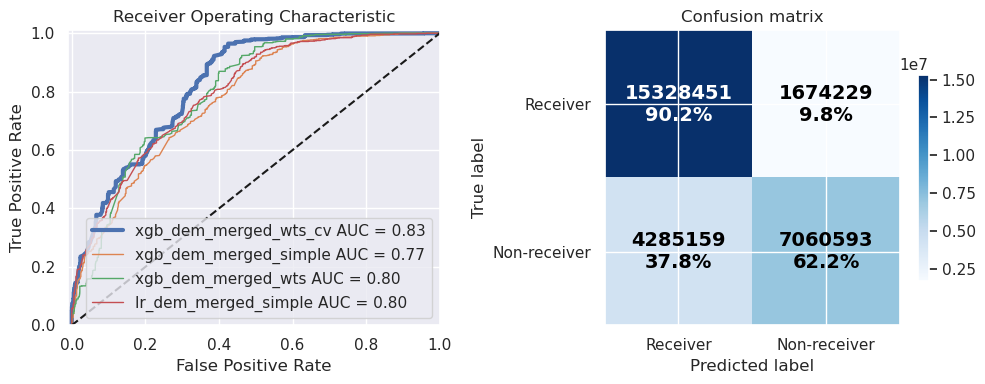

,xgb_dem_merged_wts_cv,xgb_dem_merged_simple,xgb_dem_merged_wts,lr_dem_merged_simple
accuracy,0.789781,0.756887,0.728933,0.771350
recall,0.901531,0.905640,0.794531,0.940347
precision,0.781521,0.758401,0.763232,0.757867
f1,0.837248,0.825507,0.778567,0.839303
cross_entropy,0.471202,0.549253,0.634165,0.502730
roc_auc,0.826046,0.774644,0.797634,0.795646
cohen_kappa,0.434495,0.434983,0.380615,0.458535


Actual digital wage rate: 58.40% 
Predicted digital wage rate: 67.46% 


In [5]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# build the model
estimator = XGBClassifier()
parameters = {'max_depth': np.arange(3,6,2),
              'nthread':[4],
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'min_child_weight': [11],
              'silent': [0],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000],
              'seed': [1430]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=5)
%time model.fit(X_train.to_numpy(), y_train, sample_weight=w_train)

# Get an initial score
%time score = model.score(X_train.to_numpy(), y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test.to_numpy())
y_prob = model.predict_proba(X_test.to_numpy())[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['xgb_dem_merged_simple',
                                                    'xgb_dem_merged_wts',
                                                    'lr_dem_merged_simple'],
                                    store_model=True,
                                    model_name='dem_merged_wts_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)
best_model = model.best_estimator_

In [8]:
feat_imps.head(20)

,importance
account__1.0,0.358514
fin33__2.0,0.074443
regionwb__2.0,0.073672
internetaccess__2.0,0.073480
educ__3.0,0.041597
mobileowner__2.0,0.040870
educ__2.0,0.038214
age__1,0.033245
inc_q__5.0,0.029979
age__2,0.029264


# XGBoost Summary <a class="anchor" id="summary"></a>

We have covered the basic concepts of a XGBoost classifier, and applied it to our dataset. We also explored some techniques for analyzing the performance of our model as well as tuning parameters.

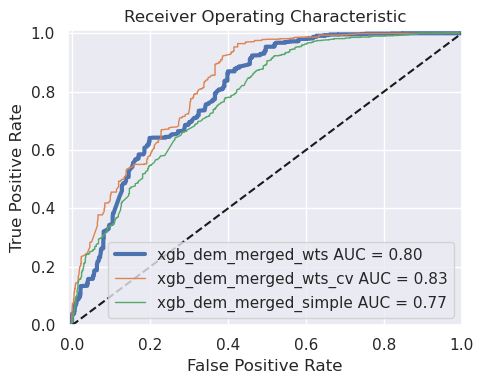

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa
xgb_dem_merged_wts,0.728933,0.794531,0.763232,0.778567,0.634165,0.797634,0.380615
xgb_dem_merged_wts_cv,0.789781,0.901531,0.781521,0.837248,0.471202,0.826046,0.434495
xgb_dem_merged_simple,0.756887,0.905640,0.758401,0.825507,0.549253,0.774644,0.434983


In [9]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)